# Hiperparámetros y Validación del Modelo


## Pensando en la validación del modelo

En principio, la validación del modelo es muy simple: después de elegir un modelo y sus hiperparámetros, podemos estimar qué tan efectivo es aplicándolo a algunos de los datos de entrenamiento y comparando las predicciones con los valores conocidos.

Esta sección mostrará primero un enfoque ingenuo para la validación del modelo y por qué
falla, antes de explorar el uso de conjuntos reservados y la validación cruzada para obtener resultados más robustos.
evaluación del modelo.

### Validación del modelo de manera incorrecta

Comencemos con el enfoque ingenuo de la validación utilizando el conjunto de datos de Iris, que vimos en el capítulo anterior.
Comenzaremos cargando los datos:

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

A continuación, elegimos un modelo e hiperparámetros. Aquí usaremos un clasificador de *k*-vecinos más cercanos con `n_neighbors=1`.
Este es un modelo muy simple e intuitivo que dice "la etiqueta de un punto desconocido es la misma que la etiqueta de su punto de entrenamiento más cercano":

In [2]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

Luego entrenamos el modelo y lo usamos para predecir etiquetas para datos cuyas etiquetas ya conocemos:

In [3]:
model.fit(X, y)
y_model = model.predict(X)

Finalmente, calculamos la fracción de puntos correctamente etiquetados:

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

¡Vemos un puntaje de precisión de 1.0, lo que indica que el 100% de los puntos fueron etiquetados correctamente por nuestro modelo!

Pero, ¿está esto realmente midiendo la precisión esperada? ¿Realmente nos hemos encontrado con un modelo que esperamos sea correcto el 100% de las veces?

Como te habrás dado cuenta, la respuesta es no.
De hecho, este enfoque contiene una falla fundamental: *entrena y evalúa el modelo con los mismos datos*.
Además, este modelo de vecino más cercano es un estimador *basado en instancias* que simplemente almacena los datos de entrenamiento y predice etiquetas comparando nuevos datos con estos puntos almacenados: ¡excepto en casos artificiales, obtendrá el 100% de precisión cada vez!

### Validación del modelo de la manera correcta: Holdout Sets

Entonces, ¿qué puede hacerse?
Se puede encontrar una mejor idea del rendimiento de un modelo usando lo que se conoce como un **conjunto de exclusión** (Holdout Sets): es decir, retenemos un subconjunto de los datos del entrenamiento del modelo y luego usamos este conjunto de exclusión para verificar el rendimiento del modelo. .
Esta división se puede hacer usando la utilidad `train_test_split` en Scikit-Learn:

In [5]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

Vemos aquí un resultado más razonable: el clasificador del vecino más cercano tiene una precisión de alrededor del 90 % en este conjunto reservado.
El conjunto reservado es similar a los datos desconocidos, porque el modelo no los ha "visto" antes.

### Validación del modelo mediante validación cruzada

Una desventaja de usar un conjunto reservado para la validación del modelo es que hemos perdido una parte de nuestros datos en el entrenamiento del modelo.
En el caso anterior, ¡la mitad del conjunto de datos no contribuye al entrenamiento del modelo!
Esto no es óptimo, especialmente si el conjunto inicial de datos de entrenamiento es pequeño.

Una forma de abordar esto es usar *validación cruzada*; es decir, hacer una secuencia de ajustes donde cada subconjunto de los datos se utiliza tanto como conjunto de entrenamiento como conjunto de validación.
Visualmente, podría parecerse a la siguiente figura:

<img src="https://raw.githubusercontent.com/fralfaro/python_ml/main/docs/introduction/images/mv_01.png">

Aquí hacemos dos pruebas de validación, usando alternativamente cada mitad de los datos como un conjunto reservado.
Usando los datos divididos de antes, podríamos implementarlo así:

In [6]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

Lo que sale son dos puntajes de precisión, que podríamos combinar (por ejemplo, tomando la media) para obtener una mejor medida del rendimiento del modelo global.
Esta forma particular de validación cruzada es una *validación cruzada doble*, es decir, una en la que hemos dividido los datos en dos conjuntos y usamos cada uno a su vez como un conjunto de validación.

Podríamos ampliar esta idea para usar aún más ensayos y más pliegues en los datos; por ejemplo, la siguiente figura muestra una representación visual de la validación cruzada de cinco pliegues.

<img src="https://raw.githubusercontent.com/fralfaro/python_ml/main/docs/introduction/images/mv_02.png">


Aquí dividimos los datos en cinco grupos y usamos cada uno de ellos para evaluar el ajuste del modelo en las otras cuatro quintas partes de los datos.
Esto sería bastante tedioso de hacer a mano, pero podemos usar la rutina de conveniencia `cross_val_score` de Scikit-Learn para hacerlo de manera sucinta:

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

Repetir la validación en diferentes subconjuntos de datos nos da una idea aún mejor del rendimiento del algoritmo.

Scikit-Learn implementa una serie de esquemas de validación cruzada que son útiles en situaciones particulares; estos se implementan a través de iteradores en el módulo `model_selection`.
Por ejemplo, podríamos querer ir al caso extremo en el que nuestro número de pliegues es igual al número de puntos de datos: es decir, entrenamos en todos los puntos menos uno en cada ensayo.
Este tipo de validación cruzada se conoce como validación cruzada *dejar uno fuera* y se puede utilizar de la siguiente manera:

In [8]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Debido a que tenemos 150 muestras, la validación cruzada sin uno arroja puntajes para 150 ensayos, y cada puntaje indica una predicción exitosa (1.0) o fallida (0.0).
Tomando la media de estos da una estimación de la tasa de error:

In [9]:
scores.mean()

0.96

## Selección del mejor modelo

Ahora que hemos explorado los conceptos básicos de validación y validación cruzada, profundizaremos un poco más en la selección de modelos y la selección de hiperparámetros.
Estos problemas son algunos de los aspectos más importantes de la práctica del aprendizaje automático, pero encuentro que esta información a menudo se pasa por alto en los tutoriales introductorios de aprendizaje automático.

De importancia central es la siguiente pregunta: *si nuestro estimador tiene un rendimiento inferior, ¿cómo debemos avanzar?*
Hay varias respuestas posibles:

- Utilizar un modelo más complicado/más flexible.
- Utilizar un modelo menos complicado/menos flexible.
- Reúne más muestras de entrenamiento.
- Reúna más datos para agregar características a cada muestra.

La respuesta a esta pregunta es a menudo contradictoria.
En particular, a veces usar un modelo más complicado dará peores resultados, ¡y agregar más muestras de entrenamiento puede no mejorar sus resultados!
La capacidad de determinar qué pasos mejorarán su modelo es lo que separa a los profesionales exitosos del aprendizaje automático de los que no lo tienen.

### La compensación entre sesgo y varianza

Fundamentalmente, encontrar "el mejor modelo" se trata de encontrar un punto óptimo en el equilibrio entre *sesgo* y *varianza*.
Considere la siguiente figura, que presenta dos ajustes de regresión al mismo conjunto de datos.

<img src="https://raw.githubusercontent.com/fralfaro/python_ml/main/docs/introduction/images/mv_03.png">


Está claro que ninguno de estos modelos se ajusta particularmente bien a los datos, pero fallan de diferentes maneras.

El modelo de la izquierda intenta encontrar un ajuste lineal a través de los datos.
Debido a que en este caso una línea recta no puede dividir con precisión los datos, el modelo de línea recta nunca podrá describir bien este conjunto de datos.
Se dice que dicho modelo *no se adapta* a los datos: es decir, no tiene suficiente flexibilidad para dar cuenta adecuadamente de todas las características de los datos. Otra forma de decir esto es que el modelo tiene un alto sesgo.

El modelo de la derecha intenta ajustar un polinomio de alto orden a través de los datos.
Aquí, el ajuste del modelo tiene suficiente flexibilidad para dar cuenta casi perfectamente de las características finas de los datos, pero aunque describe con mucha precisión los datos de entrenamiento, su forma precisa parece reflejar más las propiedades de ruido particulares de los datos que el intrínseco. propiedades de cualquier proceso que haya generado esos datos.
Se dice que dicho modelo *sobreajusta* los datos: es decir, tiene tanta flexibilidad que el modelo termina teniendo en cuenta los errores aleatorios, así como la distribución de datos subyacente. Otra forma de decir esto es que el modelo tiene una gran varianza.

Para ver esto bajo otra luz, considere lo que sucede si usamos estos dos modelos para predecir los valores *y* para algunos datos nuevos.
En los gráficos de la siguiente figura, los puntos rojos/más claros indican datos que se omiten del conjunto de entrenamiento.

<img src="https://raw.githubusercontent.com/fralfaro/python_ml/main/docs/introduction/images/mv_04.png">


El puntaje aquí es el puntaje $R^2$, o [coeficiente de determinación](https://en.wikipedia.org/wiki/Coficient_of_determination), que mide qué tan bien se desempeña un modelo en relación con una media simple de los valores objetivo . $R^2=1$ indica una coincidencia perfecta, $R^2=0$ indica que el modelo no hace nada mejor que simplemente tomar la media de los datos, y los valores negativos significan modelos aún peores.
A partir de las puntuaciones asociadas con estos dos modelos, podemos hacer una observación que se sostiene de manera más general:

- Para modelos de alto sesgo, el rendimiento del modelo en el conjunto de validación es similar al rendimiento en el conjunto de entrenamiento.
- Para modelos de alta varianza, el rendimiento del modelo en el conjunto de validación es mucho peor que el rendimiento en el conjunto de entrenamiento.

Si imaginamos que tenemos alguna capacidad para ajustar la complejidad del modelo, esperaríamos que el puntaje de entrenamiento y el puntaje de validación se comporten como se ilustra en la siguiente figura:

<img src="https://raw.githubusercontent.com/fralfaro/python_ml/main/docs/introduction/images/mv_05.png">


El diagrama que se muestra aquí a menudo se denomina *curva de validación*, y vemos las siguientes características:

- El puntaje de entrenamiento es en todas partes más alto que el puntaje de validación. Este suele ser el caso: el modelo se ajustará mejor a los datos que ha visto que a los datos que no ha visto.
- Para una complejidad de modelo muy baja (un modelo de alto sesgo), los datos de entrenamiento no se ajustan bien, lo que significa que el modelo es un predictor deficiente tanto para los datos de entrenamiento como para cualquier dato no visto anteriormente.
- Para una complejidad de modelo muy alta (un modelo de varianza alta), los datos de entrenamiento están sobreajustados, lo que significa que el modelo predice muy bien los datos de entrenamiento, pero falla para los datos no vistos anteriormente.
- Para algún valor intermedio, la curva de validación tiene un máximo. Este nivel de complejidad indica un compromiso adecuado entre sesgo y varianza.

Los medios para ajustar la complejidad del modelo varían de un modelo a otro; cuando analicemos los modelos individuales en profundidad en capítulos posteriores, veremos cómo cada modelo permite tal ajuste.

### Curvas de validación en Scikit-Learn

Veamos un ejemplo del uso de validación cruzada para calcular la curva de validación para una clase de modelos.
Aquí usaremos un modelo de *regresión polinomial*: este es un modelo lineal generalizado en el que el grado del polinomio es un parámetro ajustable.
Por ejemplo, un polinomio de grado 1 ajusta una línea recta a los datos; para los parámetros del modelo $a$ y $b$:

$$
y = ax + b
$$

Un polinomio de grado 3 ajusta una curva cúbica a los datos; para los parámetros del modelo $a, b, c, d$:

$$
y = ax^3 + bx^2 + cx + d
$$

Podemos generalizar esto a cualquier número de características polinómicas.
En Scikit-Learn, podemos implementar esto con un clasificador de regresión lineal combinado con el preprocesador polinomial.
Usaremos una *tubería* para unir estas operaciones:

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Ahora vamos a crear algunos datos a los que ajustaremos nuestro modelo:

In [11]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

Ahora podemos visualizar nuestros datos, junto con ajustes polinómicos de varios grados (ver la siguiente figura):

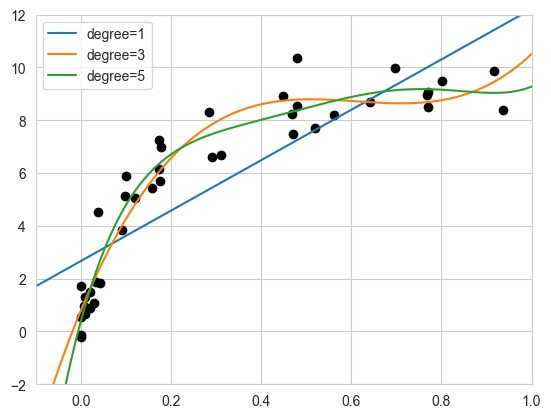

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

La perilla que controla la complejidad del modelo en este caso es el grado del polinomio, que puede ser cualquier número entero no negativo.
Una pregunta útil para responder es la siguiente: ¿qué grado de polinomio proporciona una compensación adecuada entre el sesgo (ajuste insuficiente) y la varianza (ajuste excesivo)?

Podemos avanzar en esto visualizando la curva de validación para este modelo y datos en particular; esto se puede hacer directamente usando la rutina de conveniencia ``validation_curve`` proporcionada por Scikit-Learn.
Dado un modelo, datos, nombre de parámetro y un rango para explorar, esta función calculará automáticamente tanto el puntaje de entrenamiento como el puntaje de validación en todo el rango (consulte la siguiente figura):

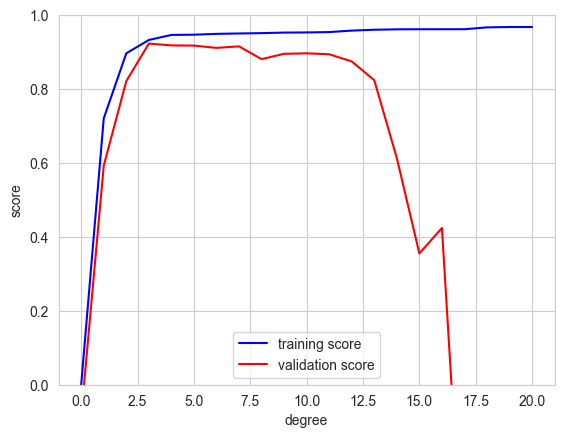

In [13]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(
    PolynomialRegression(), X, y,
    param_name='polynomialfeatures__degree',
    param_range=degree, cv=7)

plt.plot(degree, np.median(train_score, 1),
         color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1),
         color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

Esto muestra precisamente el comportamiento cualitativo que esperamos: el puntaje de entrenamiento es en todas partes más alto que el puntaje de validación, el puntaje de entrenamiento mejora monótonamente con una mayor complejidad del modelo y el puntaje de validación alcanza un máximo antes de caer cuando el modelo se vuelve demasiado ajustado.

A partir de la curva de validación, podemos determinar que el equilibrio óptimo entre sesgo y varianza se encuentra para un polinomio de tercer orden. Podemos calcular y mostrar este ajuste sobre los datos originales de la siguiente manera (ver la siguiente figura):

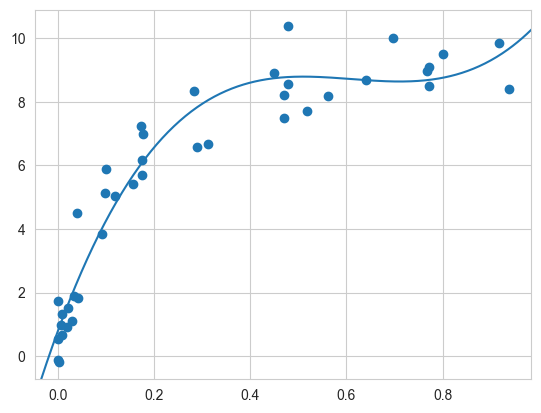

In [14]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

Tenga en cuenta que encontrar este modelo óptimo en realidad no requirió que calculáramos el puntaje de entrenamiento, pero examinar la relación entre el puntaje de entrenamiento y el puntaje de validación puede brindarnos información útil sobre el rendimiento del modelo.

## Curvas de aprendizaje

Un aspecto importante de la complejidad del modelo es que el modelo óptimo generalmente dependerá del tamaño de los datos de entrenamiento.
Por ejemplo, generemos un nuevo conjunto de datos con cinco veces más puntos (ver la siguiente figura):

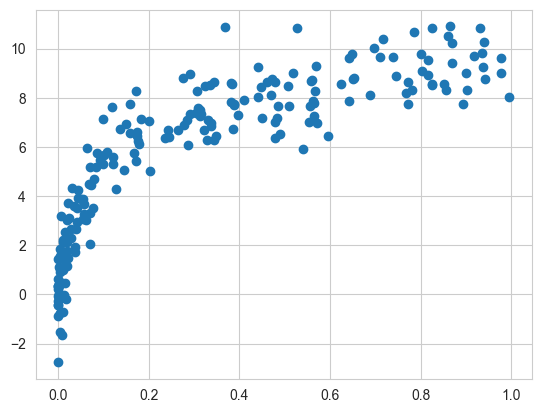

In [15]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

Ahora, dupliquemos el código anterior para trazar la curva de validación para este conjunto de datos más grande; como referencia, también representaremos gráficamente los resultados anteriores (vea la siguiente figura):

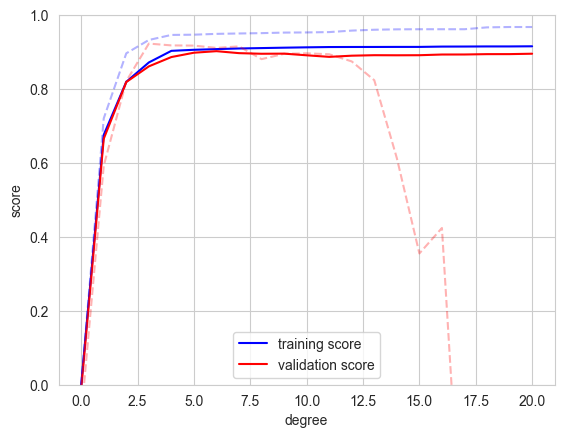

In [16]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(
    PolynomialRegression(), X2, y2,
    param_name='polynomialfeatures__degree',
    param_range=degree, cv=7)

plt.plot(degree, np.median(train_score2, 1),
         color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1),
         color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1),
         color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1),
         color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

Las líneas continuas muestran los nuevos resultados, mientras que las líneas discontinuas más tenues muestran los resultados del conjunto de datos más pequeño anterior.
Está claro a partir de la curva de validación que el conjunto de datos más grande puede admitir un modelo mucho más complicado: el pico aquí es probablemente de alrededor de un grado 6, pero incluso un modelo de grado 20 no está sobreajustando seriamente los datos: las puntuaciones de validación y entrenamiento permanecen muy cerca.

Entonces, el comportamiento de la curva de validación no tiene una sino dos entradas importantes: la complejidad del modelo y el número de puntos de entrenamiento.
Podemos obtener más información explorando el comportamiento del modelo en función de la cantidad de puntos de entrenamiento, lo que podemos hacer usando subconjuntos de datos cada vez más grandes para ajustar nuestro modelo.
Una gráfica de la puntuación de entrenamiento/validación con respecto al tamaño del conjunto de entrenamiento a veces se conoce como *curva de aprendizaje.*

El comportamiento general que esperaríamos de una curva de aprendizaje es este:

- Un modelo de una complejidad dada *sobreajustará* un pequeño conjunto de datos: esto significa que el puntaje de entrenamiento será relativamente alto, mientras que el puntaje de validación será relativamente bajo.
- Un modelo de una complejidad dada *no se ajustará* a un gran conjunto de datos: esto significa que el puntaje de entrenamiento disminuirá, pero el puntaje de validación aumentará.
- Un modelo nunca, excepto por casualidad, otorgará una mejor puntuación al conjunto de validación que al conjunto de entrenamiento: esto significa que las curvas deben seguir acercándose pero nunca cruzarse.

Con estas características en mente, esperaríamos que la curva de aprendizaje se pareciera cualitativamente a la que se muestra en la siguiente figura:

<img src="https://raw.githubusercontent.com/fralfaro/python_ml/main/docs/introduction/images/mv_06.png">


La característica notable de la curva de aprendizaje es la convergencia a un puntaje particular a medida que crece el número de muestras de entrenamiento.
En particular, una vez que tenga suficientes puntos de que un modelo en particular ha convergido, * ¡agregar más datos de entrenamiento no lo ayudará! *
La única forma de aumentar el rendimiento del modelo en este caso es utilizar otro modelo (a menudo más complejo).

### Curvas de aprendizaje en Scikit-Learn

Scikit-Learn ofrece una utilidad conveniente para calcular dichas curvas de aprendizaje a partir de sus modelos; aquí calcularemos una curva de aprendizaje para nuestro conjunto de datos original con un modelo polinomial de segundo orden y un polinomio de noveno orden (ver la siguiente figura):

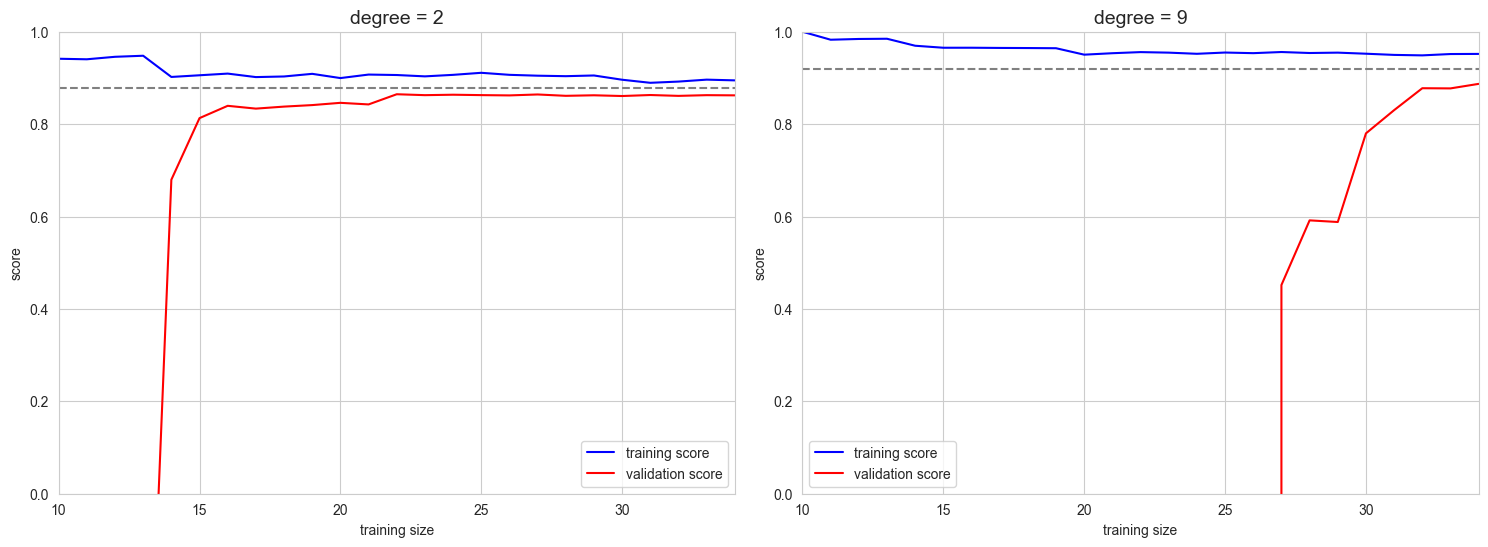

In [17]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(
        PolynomialRegression(degree), X, y, cv=7,
        train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1),
               color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1),
               color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0],
                 N[-1], color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

Este es un diagnóstico valioso, porque nos brinda una descripción visual de cómo nuestro modelo responde a cantidades crecientes de datos de entrenamiento.
En particular, cuando la curva de aprendizaje ya ha convergido (es decir, cuando las curvas de entrenamiento y validación ya están cerca una de la otra) *¡agregar más datos de entrenamiento no mejorará significativamente el ajuste!*
Esta situación se ve en el panel izquierdo, con la curva de aprendizaje para el modelo de grado-2.

La única forma de aumentar la puntuación convergente es usar un modelo diferente (generalmente más complicado).
Vemos esto en el panel de la derecha: al pasar a un modelo mucho más complicado, aumentamos el puntaje de convergencia (indicado por la línea discontinua), pero a expensas de una mayor varianza del modelo (indicada por la diferencia entre los puntajes de entrenamiento y validación). ).
Si tuviéramos que agregar aún más puntos de datos, la curva de aprendizaje para el modelo más complicado eventualmente convergería.

Trazar una curva de aprendizaje para su elección particular de modelo y conjunto de datos puede ayudarlo a tomar este tipo de decisión sobre cómo avanzar en la mejora de su análisis.

## Validación en la práctica: Grid Search

La discusión anterior pretende brindarle cierta intuición sobre el equilibrio entre el sesgo y la varianza, y su dependencia de la complejidad del modelo y el tamaño del conjunto de entrenamiento.
En la práctica, los modelos generalmente tienen más de una perilla para girar, lo que significa que los gráficos de validación y las curvas de aprendizaje cambian de líneas a superficies multidimensionales.
En estos casos, tales visualizaciones son difíciles y preferiríamos simplemente encontrar el modelo particular que maximiza el puntaje de validación.

Scikit-Learn proporciona algunas herramientas para que este tipo de búsqueda sea más conveniente: aquí consideraremos el uso de la búsqueda en cuadrícula (**Grid Search**) para encontrar el modelo polinomial óptimo.

Exploraremos una cuadrícula bidimensional de características del modelo, a saber, el grado del polinomio y la bandera que nos indica si debemos ajustar la intersección.
Esto se puede configurar usando el metaestimador `GridSearchCV` de Scikit-Learn:

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

Tenga en cuenta que, como un estimador normal, esto aún no se ha aplicado a ningún dato.
Llamar al método ``fit`` ajustará el modelo en cada punto de la cuadrícula, manteniendo un registro de las puntuaciones a lo largo del camino:

In [19]:
grid.fit(X, y);

Ahora que el modelo está ajustado, podemos pedir los mejores parámetros de la siguiente manera:

In [20]:
grid.best_params_

{'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 4}

Finalmente, si lo deseamos, podemos usar el mejor modelo y mostrar el ajuste a nuestros datos usando el código anterior (ver la siguiente figura):

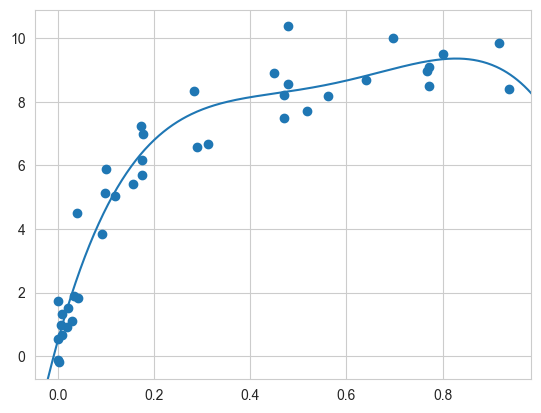

In [21]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);